In [ ]:
# Importing necessary libraries for the project
import numpy as np
import pandas as pd

from sklearn.base import ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline as base_make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from matplotlib import pyplot as plt
from tabulate import tabulate

import calendar
from datetime import datetime, timedelta

In [ ]:
# Constants for the telemarketing project
from pathlib import Path

CATEGORICAL_FEATURES = [
    "contact",
    "day_of_week",
    "default",
    "education",
    "housing",
    "job",
    "loan",
    "marital",
    "month",
    "poutcome",
    "year",
]
NUMERICAL_FEATURES = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]
BINARY_FEATURES = [
    "y",
]

DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

DATA_FILENAME = "bank-additional-full.csv"
APPROACHED_DATA_FILENAME = "approached_data.csv"
NOT_APPROACHED_DATA_FILENAME = "not_approached_data.csv"

HONOLULU_BLUE = "#1F77B4"
IMPERIAL_RED = "#F0534F"
PERSIAN_GREEN = "#27A69A"

### Time-based Data Split Strategy

- **Test period selection**: 2010 data serves as the test set to ensure realistic and future-proof evaluation

- **Training and validation periods**: 2008-2009 data is used for model training and validation phases

- **Temporal integrity**: The time-based split of training and test datasets maintains chronological order, preventing data leakage where future information inappropriately influences model training

- **Generalization assessment**: This approach enables honest evaluation of how effectively the model performs on completely unseen data

- **Business application**: The split structure supports realistic business strategy simulations that mirror actual real-world deployment conditions

**note**

We deliberately avoided stratifying the data splits by the target variable. Stratification requires random shuffling, which is fundamentally incompatible with the strict chronological ordering necessary for a time-series problem.
Our priority is to prevent data leakage and create a realistic train/test split that respects the arrow of time. The class imbalance is instead addressed at the model training stage using the class_weight parameter. This method correctly handles the imbalance without compromising the temporal integrity of our validation framework.

In [90]:
# Load not_approached dataset
df = pd.read_csv(PROCESSED_DATA_DIR / NOT_APPROACHED_DATA_FILENAME)

In [91]:
# Define X and y for modeling
X = df.drop(columns=["y"], axis=1)
y = df["y"]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X.head()

X shape: (39673, 17), y shape: (39673,)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,year
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,2008
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,2008
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,2008
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,2008
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,2008


In [92]:
# dertemine the split in train and test data.
print(X.groupby(['year']).size().sort_index())
# Ratio between 2010 data and the rest
print(f"Ratio of 2010 data to the rest: {X[X['year'] == 2010].shape[0] / X[X['year'] != 2010].shape[0]:.2f}")

year
2008    27655
2009    10685
2010     1333
dtype: int64
Ratio of 2010 data to the rest: 0.03


Our time-based data split revealed a key challenge: the most recent data available for testing (2010) is significantly smaller than the preceding training years. Standard evaluation on this set alone would be statistically unreliable.

Therefore, we have adopted a more sophisticated validation protocol to ensure trustworthiness:

### Model selection will be driven by a stable, averaged score from a rigorous time-series cross-validation on the large 2008-2009 dataset

**The Problem with unequal spaced time series:**

TimeSeriesSplit splits by row count, not actual time duration. This means:
1. **Unequal Spacing:** Test sets (same number of rows) can cover vastly different **time durations**.
2. **Imbalanced Periods:** Different test sets will represent different years/contexts (e.g., 2008 data vs. 2009 data).

**Result:** Cross-validation metrics (RMSE, MAE) are **not truly comparable** across folds, as they reflect performance over different time horizons and contexts.

**How to Address It:**
1. **Keep TimeSeriesSplit**: It's still correct for chronological splits.
2. **Smart Feature Engineering (Key!)**:
   * **Time-based Features:** Add year, month, day_of_week, etc., so the model knows the temporal context.
   * **Gap Features:** Add days_since_last_observation or observations_in_last_X_days to inform the model about data density.
3. **Careful Evaluation**:
   * Report **metrics for each individual fold** to see how performance shifts over time/contexts.
   * **Contextualize** results; explain performance changes based on the different periods covered by each fold


### The small 2010 test set will then serve as a final, mandatory sanity check, with its performance explicitly framed by confidence intervals to account for potential variance.

**References need to be checked**

Statistical Issues with Small Test Sets
This issue is well-documented in statistics and machine learning:

Reference: Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning (2nd ed.). Springer.
Chapter 7 discusses model assessment and the impact of sample size on estimation stability. Small test sets lead to high-variance estimates, necessitating robust evaluation methods like cross-validation or confidence intervals.


Reference: Kohavi, R. (1995). A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection. IJCAI.
Kohavi emphasizes that small test sets produce unreliable performance estimates and recommends techniques like cross-validation or confidence intervals to quantify uncertainty.




### Concept drift and temporal imbalance

Our dataset is influenced by two interacting temporal phenomena. First, concept drift, which could be driven by for example the 2008 financial crisis, has rendered older data less predictive of current outcomes. Second, we observe a temporal instance imbalance, where this outdated 2008-era data is overrepresented in volume. While each issue is problematic on its own, their combination is especially harmful: the volume imbalance significantly amplifies the negative impact of the drift. To address this, we apply time-based sample weighting — not to equalize instance counts, but to rebalance the influence of different time periods. This ensures the model prioritizes learning from more recent, and therefore more relevant, observations."


### Feature transformation 

Some distributions have a heavy tail. In order to quickly check this the describe function can be used. 

In [ ]:
# Loading not approached dataset
not_approached = pd.read_csv(PROCESSED_DATA_DIR / NOT_APPROACHED_DATA_FILENAME)

In [100]:
# Decribe the dataset
not_approached.describe()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year
count,39673.000000,39673.000000,39673.000000,39673.000000,39673.000000,39673.000000,39673.000000,39673.000000,39673.000000
mean,39.954226,2.596048,0.165062,93.584568,-40.585131,3.721927,5172.297769,0.092582,2008.336526
std,10.182739,2.808054,1.532183,0.567702,4.514013,1.684333,67.546055,0.289849,0.538965
min,17.000000,1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,2008.000000
25%,32.000000,1.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000,0.000000,2008.000000
50%,38.000000,2.000000,1.100000,93.876000,-41.800000,4.857000,5195.800000,0.000000,2008.000000
75%,47.000000,3.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,2009.000000
max,98.000000,56.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,2010.000000


Age: Is slightly skewed and can be handled with standard scaler.

Campaign: Is serverly skewed and problamatic for standardization. Max value is 56 while 75%Q is 3 and the mean is 2.567. Apply power transformation like log.

emp.var.rate: Does not have any signs of skew

cons.price.idx: Does not have any signs of skew

cons.conf.idx: Does not have any signs of skew

euribor3m: Does not have any signs of skew

nr.empployed: Does not have any signs of skew

year: Does not have any signs of skew

y: target variable

In [96]:
# Load approached dataset
approached = pd.read_csv(PROCESSED_DATA_DIR / APPROACHED_DATA_FILENAME)
approached.shape

(1515, 21)

In [101]:
# decribe features pdays and previous
approached.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year
count,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000
mean,41.852805,1.822442,6.014521,1.660726,-2.096238,93.342507,-38.341386,0.985949,5029.244686,0.638284,2009.455446
std,15.296112,1.241414,3.824906,0.934306,0.833032,0.783216,6.628399,0.533622,52.308986,0.480656,0.542599
min,17.000000,1.000000,0.000000,1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,2008.000000
25%,30.000000,1.000000,3.000000,1.000000,-2.900000,92.649000,-42.000000,0.718000,4991.600000,0.000000,2009.000000
50%,37.000000,1.000000,6.000000,1.000000,-1.800000,93.200000,-38.300000,0.879000,5017.500000,1.000000,2009.000000
75%,52.000000,2.000000,7.000000,2.000000,-1.700000,94.055000,-31.400000,1.044000,5076.200000,1.000000,2010.000000
max,98.000000,13.000000,27.000000,7.000000,-0.100000,94.767000,-26.900000,4.286000,5195.800000,1.000000,2010.000000


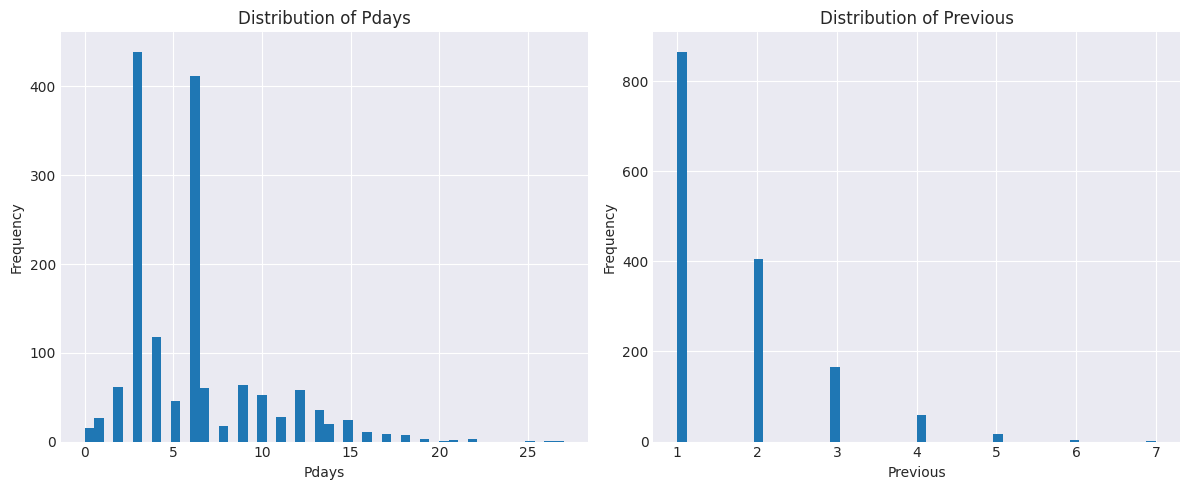

In [102]:
# create distribution plots for pdays and previous
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
approached["pdays"].hist(bins=50, ax=axes[0], color=HONOLULU_BLUE)
axes[0].set_title("Distribution of Pdays")
axes[0].set_xlabel("Pdays")
axes[0].set_ylabel("Frequency")
approached["previous"].hist(bins=50, ax=axes[1], color=HONOLULU_BLUE)
axes[1].set_title("Distribution of Previous")
axes[1].set_xlabel("Previous")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

** Analysis of appoached values

Age: Is slightly skewed and can be handled with standard scaler.

Campaign: Is serverly skewed and problamatic for standardization. Max value is 13 while 75%Q is 2 and the mean is 1.82. Apply power transformation like log.

pdays: Moderate skew, log transformation advised

previous: Strong skew, log transformation advised

emp.var.rate: Does not have any signs of skew

cons.price.idx: Does not have any signs of skew

cons.conf.idx: Does not have any signs of skew

euribor3m: Does not have any signs of skew

nr.empployed: Does not have any signs of skew

year: Does not have any signs of skew

y: target variable

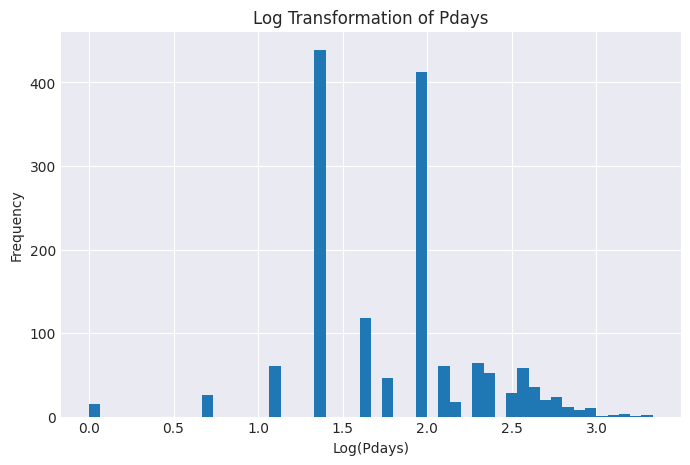

In [105]:
# apply log transformation to pdays and plot the distribution
approached["log_pdays"] = np.log1p(approached["pdays"])
fig, ax = plt.subplots(figsize=(8, 5))
approached["log_pdays"].hist(bins=50, ax=ax, color=HONOLULU_BLUE)
ax.set_title("Log Transformation of Pdays") 
ax.set_xlabel("Log(Pdays)")
ax.set_ylabel("Frequency") 
plt.show()

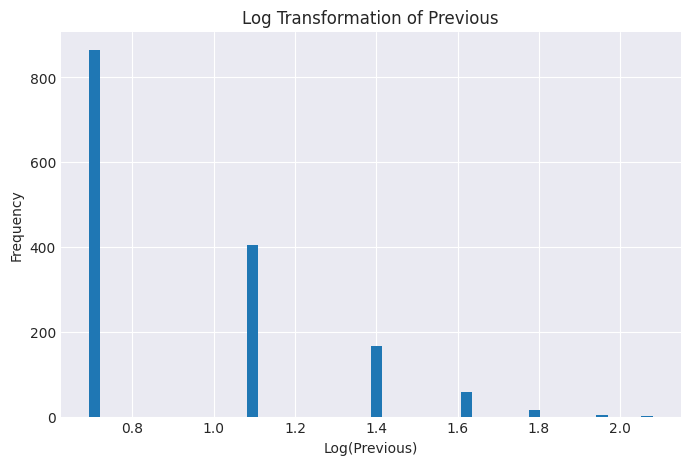

In [110]:
# apply log transformation to previous and plot the distribution
approached["log_previous"] = np.log1p(approached["previous"])
fig, ax = plt.subplots(figsize=(8, 5))
approached["log_previous"].hist(bins=50, ax=ax, color=HONOLULU_BLUE)
ax.set_title("Log Transformation of Previous")
ax.set_xlabel("Log(Previous)")
ax.set_ylabel("Frequency")
plt.show()

In [111]:
# describe the log transformed features
approached[["log_pdays", "log_previous"]].describe()

,log_pdays,log_previous
count,1515.000000,1515.000000
mean,1.815513,0.928392
std,0.516466,0.302679
min,0.000000,0.693147
25%,1.386294,0.693147
50%,1.945910,0.693147
75%,2.079442,1.098612
max,3.332205,2.079442


The log transformation of previous did not normalize the data. However it was a good step in the right direction since extreme values are limited.

### Performance metrics

**Core metric**

The project aims to create stakeholder value by maximizing the profit of the telemarketing department. Profit maximalization based ont graph??

- Expected Profit = (Number of True Positives * Revenue_per_sale) - (Number of Calls Made * Cost_per_call)

additionally



**Model calibration**

Calabritaion is essential since the strategic eval module depends on probabilities. Why needed:
- Meaningfull thresholds: if the probabilities are not calibrated there is no meaning in 'call all customers with  >0.5 probability. If the model is overconfident, the actual chance of success might be way lower.

- Accurrate profit predictions: The profit simulations relies on the predicted probabilities. Incorrect probabilities will result in incorrect profit estimations.

- Trust: For the stakeholder to make a good data driven decision they need to trust the numbers the model generates.

How to assess calibration (to do)

- Reliability diagram (Calibration curve)
- Brier score


Notities:

Wat is de winst op basis van de confusion matrix. Kosten en baten.

Het beste model is het model dat de beste winst realiseerd. Train beste model.

Winst per gebelde persoon, om test en train set goed te kunnen vergelijken.

Voor stakeholders, hoofdzaken van het onderzoek. Dus niet te technisch. 

In [164]:
# the mean of calls during this campaign for the not approached dataset
mean_calls = not_approached["campaign"].mean() 
print(f"Mean calls during this campaign for not approached dataset: {mean_calls:.2f} times")
# the average duration of calls for the not approached dataset
# needs to be claculated for the not approached set but column is dropped
# quick peak in the original dataset leads to a mean of 258 seconds
mean_duration_minutes = 258 / 60
print(f"Mean duration of calls for not approached dataset: {mean_duration_minutes:.2f} minutes")
# average time spent per customer
average_time_on_phone_per_customer = mean_duration_minutes * mean_calls
print(f"Average time spent per customer on phone: {average_time_on_phone_per_customer:.2f} minutes")
# including the start and end of the call including the time to prepare and follow up
# preparation and follow up is estimated to be 3 minutes per call
prep_time_per_call = 3
total_prep_time = prep_time_per_call * mean_calls
average_time_per_customer = average_time_on_phone_per_customer + total_prep_time
print(f"Average time spent per customer including preparation and follow up: {average_time_per_customer:.2f} minutes")

Mean calls during this campaign for not approached dataset: 2.60 times
Mean duration of calls for not approached dataset: 4.30 minutes
Average time spent per customer on phone: 11.16 minutes
Average time spent per customer including preparation and follow up: 18.95 minutes


In [168]:
# calculate the current profit for the not approached dataset for a selected year
selected_year = 2008
hourly_wage = 35  # in euro

subset = not_approached[not_approached["year"] == selected_year]

cost_per_contact = hourly_wage * (average_time_per_customer / 60)
profit_per_success = 200

total_costs = subset.shape[0] * cost_per_contact
profit = subset[subset["y"] == 1].shape[0] * profit_per_success

total_profit = profit - total_costs
print(f"Cost per contact: {cost_per_contact:.2f} euro")
formatted_profit = f"{total_profit:,.0f}".replace(",", ".")
print(f"Total profit for year {selected_year}: {formatted_profit} euro")


Cost per contact: 11.05 euro
Total profit for year 2008: -38.522 euro
